In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download stopwords if not already present
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aarushisharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [4]:
# Load and preprocess data
df = pd.read_csv("msd_dataset_with_only_clean_lyrics.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

In [5]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

In [6]:
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]

In [7]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

In [8]:
# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

In [9]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

In [10]:
# Create sliding windows
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

In [11]:
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

In [12]:
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

In [13]:
X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

In [14]:
embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [15]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()
meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

In [16]:
X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [17]:
# Split
test_size = 0.3
val_size = 0.5
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=test_size, stratify=y_labels, random_state=SEED
)
X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=val_size, stratify=y_temp_labels, random_state=SEED
)

In [18]:
# Custom Attention Layer (Word-level)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wa = self.add_weight(name='Wa', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.ua = self.add_weight(name='ua', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, h):
        # h: (batch, timesteps, features)
        uit = tf.tanh(tf.tensordot(h, self.Wa, axes=1) + self.ba)
        ait = tf.tensordot(uit, self.ua, axes=1)  # (batch, timesteps, 1)
        ait = tf.squeeze(ait, -1)  # (batch, timesteps)
        ait = tf.nn.softmax(ait, axis=1)  # (batch, timesteps)
        ait = tf.expand_dims(ait, -1)  # (batch, timesteps, 1)
        weighted_input = h * ait  # (batch, timesteps, features)
        context = tf.reduce_sum(weighted_input, axis=1)  # (batch, features)
        return context

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Build and train LSTM+Attention model
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
              weights=[embedding_matrix],trainable=True, name="embed_w2v")(input_lyrics)

# Convolutional n-gram layer
x = Conv1D(64, kernel_size=5, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)

# Bi-LSTM with dropout and recurrent_dropout
x = Bidirectional(LSTM(64,
                       return_sequences=True,
                       dropout=0.3,
                       recurrent_dropout=0.2))(x)

# Attention on top of that…
x = AttentionLayer()(x)
x = Dropout(0.3)(x)

In [21]:
input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

In [22]:
model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Early stopping
early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.1766 - loss: 2.4948 - val_accuracy: 0.3205 - val_loss: 2.0755
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.2908 - loss: 2.1132 - val_accuracy: 0.3868 - val_loss: 1.8682
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.3829 - loss: 1.9490 - val_accuracy: 0.4423 - val_loss: 1.7189
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.4185 - loss: 1.7573 - val_accuracy: 0.4722 - val_loss: 1.5975
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4545 - loss: 1.6718 - val_accuracy: 0.4765 - val_loss: 1.5196
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5033 - loss: 1.5600 - val_accuracy: 0.5064 - val_loss: 1.4598
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5273 - loss: 1.4398 - val_accuracy: 0.5299 - val_loss: 1.3914
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5627 - loss: 1.3243 - val_accuracy: 0.55

In [24]:
# Evaluate
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy on held-out set: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Test Accuracy on held-out set: 0.6389

Classification Report:
              precision    recall  f1-score   support

       Blues       0.61      0.63      0.62        30
     Country       0.14      0.20      0.16        15
  Electronic       0.63      0.55      0.59        22
        Folk       1.00      0.25      0.40         4
        Jazz       0.50      0.41      0.45        32
       Latin       0.33      0.20      0.25        10
       Metal       0.58      0.44      0.50        25
         Pop       0.60      0.65      0.62        69
        Punk       0.31      0.44      0.36         9
         Rap       0.92      0.88      0.90        93
      Reggae       0.91      0.64      0.75        33
         RnB       0.78      0.64      0.70        11
        Rock       0.59      0.69      0.63       115

    accuracy                           0.64       468
   macro avg       0.61      0.51      0.53       468
weighted avg       0.66      0.6

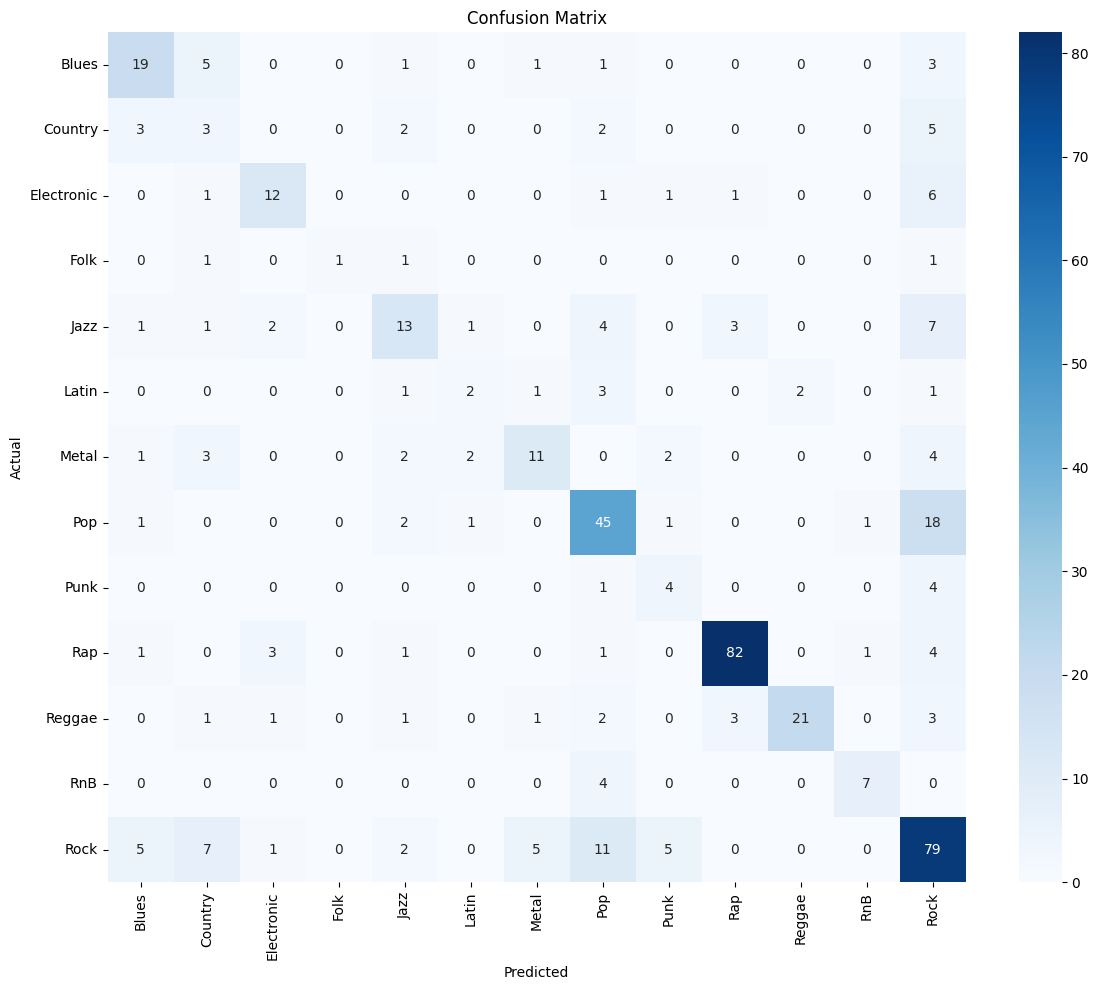

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [31]:
# Random sample of predictions vs actual
sample_idxs = np.random.choice(len(X_test_lyrics), size=5, replace=False)
for i in sample_idxs:
    actual = le.inverse_transform([y_test_labels[i]])[0]
    predicted = le.inverse_transform([y_pred[i]])[0]
    print(f"\nSample {i}")
    print("Actual Genre   :", actual)
    print("Predicted Genre:", predicted) 


Sample 57
Actual Genre   : Rock
Predicted Genre: Rock

Sample 207
Actual Genre   : Electronic
Predicted Genre: Electronic

Sample 139
Actual Genre   : Rock
Predicted Genre: Rock

Sample 44
Actual Genre   : Rock
Predicted Genre: Rock

Sample 327
Actual Genre   : Reggae
Predicted Genre: Rock
